## 1. Постановка задачи


**Бизнес-задача:** произвести сегментацию существующих клиентов, проинтерпретировать эти сегменты и определить стратегию взаимодействия с ними.

**Техническая задача для вас как для специалиста в Data Science:** построить модель кластеризации клиентов на основе их покупательской способности, частоты заказов и срока давности последней покупки, определить профиль каждого из кластеров.

**Основные цели проекта:**
1. Произвести предобработку набора данных.
2. Провести разведывательный анализ данных и выявить основные закономерности.
3. Сформировать категории товаров и клиентов. 
4. Построить несколько моделей машинного обучения, решающих задачу кластеризации клиентов, определить количество кластеров и проинтерпретировать их.
5. Спроектировать процесс предсказания категории интересов клиента и протестировать вашу модель на новых клиентах.



## 2. Знакомство с данными. 

In [209]:
import pandas as pd 
import numpy as np 
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn import mixture
from sklearn import manifold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn import cluster
from sklearn import metrics
from sklearn import model_selection
from sklearn import decomposition
from sklearn import ensemble
import warnings 

from IPython.display import display, HTML

warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True

In [102]:
data = pd.read_csv(
    "customer_segmentation_project.csv", 
    encoding="ISO-8859-1", 
    dtype={'CustomerID': str,'InvoiceID': str}
)
data = data.copy()
print('Data shape: {}'.format(data.shape))
data.head(5)

Data shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


Проведём анализ структуры таблицы.


### Задание 2.1
Сколько столбцов в данных кодируются числовыми типами (int/float)?

In [103]:
df_numerics_only = data.select_dtypes(include=np.number)

# список имен числовых столбцов
colnames_numerics_only = data.select_dtypes(include=np.number).columns.tolist()

#  количество числовых столбцов
print(len(colnames_numerics_only))

2


### Задание 2.2
Выберите столбцы, в которых есть хотя бы один пропуск

In [104]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

### Задание 2.3
Укажите, за какой промежуток времени представлены данные:



In [105]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
print(f'{data['InvoiceDate'].dt.date.min()} - {data['InvoiceDate'].dt.date.max()}')

2010-12-01 - 2011-12-09


### Задание 2.4

1) Каково максимальное количество товаров в заказе?

2) Каково минимальное количество товаров в заказе? 

3) Сколько, согласно данным, стоит самый дешёвый товар (за исключением товаров с отрицательной стоимостью)?

In [106]:
display(data.describe())
data['UnitPrice'].sort_values()

,Quantity,InvoiceDate,UnitPrice
count,541909.000000,541909,541909.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114
min,-80995.000000,2010-12-01 08:26:00,-11062.060000
25%,1.000000,2011-03-28 11:34:00,1.250000
50%,3.000000,2011-07-19 17:17:00,2.080000
75%,10.000000,2011-10-19 11:27:00,4.130000
max,80995.000000,2011-12-09 12:50:00,38970.000000
std,218.081158,NaN,96.759853


299984   -11062.06
299983   -11062.06
40984         0.00
52217         0.00
52262         0.00
            ...   
16356     13541.33
43703     16453.71
43702     16888.02
524602    17836.46
222681    38970.00
Name: UnitPrice, Length: 541909, dtype: float64

### Задание 2.5
1) Сколько уникальных клиентов покупали товары за период выгрузки датасета?

2) Сколько уникальных стран содержится в столбце Country (исключая специальный код 'Unspecified', обозначающий неопределенную страну)?

3) Идентификатор самого популярного товара (StockCode):


In [107]:
print(data['CustomerID'].nunique(), 'уникальных клиентов')
print(data[data['Country'] != 'Unspecified']['Country'].nunique(), 'уникальных стран')
print(data['StockCode'].value_counts().index[0], 'идентификатор самого популярного товара')

4372 уникальных клиентов
37 уникальных стран
85123A идентификатор самого популярного товара


## 3. Предобработка и очистка данных

### Задание 3.1

1) Сколько всего в таблице пропущенных значений?

2) Пропуски в столбце с идентификатором клиента и описанием товара свидетельствуют о некорректных/незавершённых транзакциях.  
Удалим строки, содержащие пропуски в этих столбцах.



In [108]:
print(data.isnull().sum().sum(), 'всего пропусков')
data = data.dropna(subset=['CustomerID', 'StockCode'], axis =0)
data.shape

136534 всего пропусков


(406829, 8)

### Задание 3.2
Следом за пропусками проверим наличие дубликатов.

1) Сколько в таблице полностью дублирующихся записей?

2) Удалите дубликаты из таблицы. Сколько строк осталось?



In [109]:
print(data.duplicated().sum())
data = data.drop_duplicates()
data.shape

5225


(401604, 8)

### Задание 3.3
Проверим, что все записи из таблицы с отрицательным количеством товара действительно являются возвратными транзакциями. Если транзакция не является возвратом, но содержит отрицательное количество товара, это будет поводом считать её выбросом. 

Сколько транзакций из таблицы negative_quantity не содержат в номере заказа признак возврата?

In [110]:
returns = data[(data['Quantity'] < 0) & ~(data['InvoiceNo'].str.startswith('C'))]
returns.shape

(0, 8)

Определим, сколько уникальных товаров указано в транзакции для каждой уникальной пары «клиент-заказ»:


In [111]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.head()

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


### Задание 3.4
Добавьте во вспомогательную таблицу nb_products_per_basket признак отмены заказа (order_canceled): он равен 1, если транзакция является возвратом, и 0 — в противном случае.

Сколько процентов заказов в таблице являются возвратами? Ответ приведите в виде целого числа.


In [112]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x: 1 if (x.startswith('C')) else 0)
nb_products_per_basket['order_canceled'].value_counts(normalize=True) * 100

order_canceled
0    83.533123
1    16.466877
Name: proportion, dtype: float64

Давайте поближе взглянем на отмененные заказы:


In [113]:
data[data['CustomerID'] == '12346']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom


Можно заметить пару заказ-отмена

### Задание 3.5
Проверим, что для каждой отменённой транзакции в базе данных существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара.

In [114]:
negative_quantity = data[(data['Quantity']<0)]
returns = negative_quantity.copy()
returns.reset_index(inplace=True)
# Меняем количество на положительное 
returns['Quantity'] = -returns['Quantity'] 
# Соединяем оригинальный сет и возвраты
matched = pd.merge(returns, data,
                    on=['StockCode', 'CustomerID', 'Quantity'], how='inner')
matched.drop_duplicates(subset='index', inplace=True)
print(f'Количество несовпадений: {negative_quantity.shape[0] - matched.shape[0]}')


Количество несовпадений: 5626


### Задание 3.6
Выдвигаем новую гипотезу: для каждой отменённой транзакции в базе данных существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара, если на товар не распространяются скидки.



In [115]:
negative_quantity_d = negative_quantity[(negative_quantity['StockCode'] != 'D')]
returns_d = negative_quantity_d.copy()
returns_d.reset_index(inplace=True)
# Меняем количество на положительное 
returns_d['Quantity'] = -returns_d['Quantity'] 
# Соединяем оригинальный сет и возвраты
matched = pd.merge(returns_d, data,
                    on=['StockCode', 'CustomerID', 'Quantity'], how='inner')
matched.drop_duplicates(subset='index', inplace=True)
print(f'Количество несовпадений: {negative_quantity_d.shape[0] - matched.shape[0]}')

Количество несовпадений: 5549


In [116]:
data[(data['CustomerID'] == '15311') & (data['StockCode'] == '35004C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
9200,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-05 13:55:00,4.65,15311,United Kingdom
18196,C537805,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-08 13:18:00,4.65,15311,United Kingdom
28630,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-13 15:07:00,4.65,15311,United Kingdom
39381,C539640,35004C,SET OF 3 COLOURED FLYING DUCKS,-3,2010-12-20 15:27:00,4.65,15311,United Kingdom
44157,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-05 11:41:00,4.65,15311,United Kingdom
59542,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-17 13:39:00,4.65,15311,United Kingdom
78333,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,2011-02-01 12:14:00,4.65,15311,United Kingdom


* Проблема в том, что заказ на покупку данного товара от клиента поступил раньше декабря 2010 года, а этих данных в нашей таблице нет. 

* Также клиент может отменить не весь заказ, а только его часть.

Создадим в данных о транзакциях признак QuantityCanceled, который будет указывать на количество возвращённого впоследствии товара для каждой транзакции.  


In [117]:
# Функция get_quantity_canceled() принимает на вход таблицу с транзакциями и возвращает объект Series — столбец, 
# в котором указано количество возвращённого впоследствии товара для каждой транзакции.
def get_quantity_canceled(data):
    # Инициализируем Series той же длины, что и столбцы таблицы, нулями
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for col in negative_quantity.itertuples():
        # Создаем DataFrame из всех контрагентов
        df_test = data[(data['CustomerID'] == col.CustomerID) &
                        (data['StockCode']  == col.StockCode) & 
                        (data['InvoiceDate'] < col.InvoiceDate) & 
                        ((quantity_canceled.loc[col.Index] - col.Quantity) <= data['Quantity'])].copy()
        # Транзация-возврат не имеет контрагента - ничего не делаем
        if (df_test.shape[0] == 0): 
            continue
        # Транзакция-возврат имеет одного и более контрагентов
        # Добавляем количество отмененного в столбец QuantityCanceled 
        else:
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = quantity_canceled.loc[index_order] - col.Quantity       
    return quantity_canceled

quantity_canceled = get_quantity_canceled(data)

### Задание 3.7
Подсчитайте суммарное количество отмененных товаров в столбце QuantityCanceled. 


In [118]:
data['QuantityCanceled'] = quantity_canceled
data['QuantityCanceled'].sum()

248146.0

## Задание 3.8
Теперь, когда мы разобрались с транзакциями-возвратами, они больше нам не понадобятся. 
Удалите из таблицы транзакции, в поле которых указано отрицательное количество товара.  
Сколько записей осталось?

In [119]:
data = data[data['Quantity'] > 0]
data.shape

(392732, 9)

### Задание 3.9
Найдем коды товаров, которые начинаются с латинских букв. 

1) Сколько уникальных специальных видов транзакций вам удалось найти?

Специальные операции не характеризуют клиентов, поэтому такие записи не нужны. Удалиv все специальные транзакции из таблицы. 

2) Сколько записей осталось?



In [120]:
product_codes = data[data['StockCode'].str.contains('^[a-zA-Z]\d*', regex=True)]
print(product_codes['StockCode'].value_counts())
data['StockCode'].value_counts()

StockCode
POST            1099
M                285
C2               133
DOT               16
BANK CHARGES      12
PADS               4
Name: count, dtype: int64


StockCode
85123A    2023
22423     1714
85099B    1615
84879     1395
47566     1390
          ... 
20678        1
90059D       1
90168        1
90169        1
23843        1
Name: count, Length: 3665, dtype: int64

In [121]:
data = data[data['StockCode'].str.match('^\d')]
data.shape

(391183, 9)

### Задание 3.10
На некоторые товары установлена цена в 0 фунтов стерлингов. 

1) В скольких транзакциях цена за единицу товара равна 0?

2) Таких транзакций оказалось менее 1 %, поэтому от них можно просто избавиться.  
Сколько записей осталось?



In [122]:
print(data[data['UnitPrice'] == 0].shape)
data = data[data['UnitPrice'] != 0]
data.shape

(33, 9)


(391150, 9)

In [123]:
data.to_csv('data_eda.csv')

## 4. Разведывательный анализ данных

In [161]:
data = pd.read_csv('data_eda.csv')

### Задание 4.1
Выясним, в каких странах живут клиенты.


In [162]:
country_df = data[['Country', 'CustomerID']]
# Оставим только уникальных клиентов
country_df = country_df.drop_duplicates()
country_df = country_df.groupby('Country').count()
country_df = country_df.sort_values('CustomerID', ascending=False)
display(country_df.head())

fig = px.choropleth(country_df, locations=country_df.index, locationmode = 'country names', color='CustomerID', scope='world', color_continuous_scale = 'spectral')
fig.show()

,CustomerID
Country,
United Kingdom,3916
Germany,94
France,87
Spain,30
Belgium,25


### Задание 4.2
Топ-3 стран по количеству поступающих заказов.




In [163]:
country_df = data[['Country', 'InvoiceNo']]

country_df = country_df.groupby('Country').count()
country_df = country_df.sort_values('InvoiceNo', ascending=False)
display(country_df.head())
fig = px.bar(country_df.head())
fig.show()

,InvoiceNo
Country,
United Kingdom,348872
Germany,8643
France,8019
EIRE,7126
Spain,2417


### Задание 4.3
Давайте добавим в датасет общую цену заказа, назовём её TotalPrice.

 **TotalPrice = UnitPrice * (количество товаров в заказе - количество возвращённых товаров).**


In [164]:
data['TotalPrice'] = data['UnitPrice'] * (data['Quantity'] - data['QuantityCanceled'])
print(f'Средняя стоимость заказов = {round(data['TotalPrice'].mean())}')

Средняя стоимость заказов = 21


### Задание 4.4

Постройте визуализацию и выделите топ-3 стран, клиенты из которых приносят компании больше всего выручки:


In [165]:
country_df = data[['Country', 'TotalPrice']]

country_df = country_df.groupby('Country').sum()
country_df = country_df.sort_values('TotalPrice', ascending=False)
display(country_df.head())
fig = px.bar(country_df.head())
fig.show()

,TotalPrice
Country,
United Kingdom,6787928.85
Netherlands,283443.54
EIRE,246894.08
Germany,201129.28
France,181572.84


### Задание 4.5
Добавим временные признаки месяца, дня недели и часа совершения покупки.  
Определим самые прибыльные месяца.

In [166]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['Date'] = data['InvoiceDate'].dt.date
data['Month'] = data['InvoiceDate'].dt.month
data['Day_of_week'] = data['InvoiceDate'].dt.weekday
data['Hour'] = data['InvoiceDate'].dt.hour

month_df = data[['Month', 'TotalPrice']]
month_df = month_df.groupby('Month').sum()
month_df = month_df.sort_values('TotalPrice', ascending=False)
display(month_df.head())
fig = px.bar(month_df, x = month_df.index, y = 'TotalPrice')
fig.show()

,TotalPrice
Month,
11,1119205.84
10,965490.13
9,924567.01
12,893060.47
5,647161.65


### Задание 4.6
Визуализируем количество заказов для каждого дня недели.


In [167]:
day_df = data[['Day_of_week', 'TotalPrice']]
day_df = day_df.groupby('Day_of_week').sum()
display(day_df)
fig = px.bar(day_df)
fig.show()

,TotalPrice
Day_of_week,
0,1299543.41
1,1546809.47
2,1534556.01
3,1887161.31
4,1217519.33
6,767615.34


### Задание 4.7
=
Сгруппируйте данные по датам и часам совершения транзакции и найдите количество заказов на каждый день-час. Затем найдите среднее количество ежедневно поступающих заказов в каждый из часов.

Постройте визуализацию, отражающую распределение среднего количества ежедневно поступающих заказов по времени суток (часу совершения транзакции).

Выберите верные утверждения:
* Больше всего заказов совершается в дневное время в интервале от 18 до 20 часов
* Больше всего заказов совершается в вечернее время в интервале от 10 до 15 часов
* Начиная с 21 часа вечера и до 6 утра (не включительно) заказы не поступают 
* Заказы поступают во все периоды дня


In [168]:
date_hour_df = data[['Date', 'Hour', 'Quantity']]
date_hour_df = date_hour_df.groupby(['Date', 'Hour']).mean().reset_index()
display(date_hour_df)
fig = px.bar(date_hour_df, x = 'Hour', y = 'Quantity')
fig.show()

,Date,Hour,Quantity
0,2010-12-01,8,13.311111
1,2010-12-01,9,21.885906
2,2010-12-01,10,25.666667
3,2010-12-01,11,6.472934
4,2010-12-01,12,10.070388
...,...,...,...
2848,2011-12-09,8,26.223214
2849,2011-12-09,9,1416.051724
2850,2011-12-09,10,15.875000
2851,2011-12-09,11,9.763359


## 5. RFM-сегментация клиентов: часть 1

Сформируем признаки, на основе которых будем производить сегментацию клиентов.

Воспользуемся методом RFM.

Нужно рассчитать RFM-характеристики для каждого из клиентов в датасете, и на их основе с помощью методов кластеризации построить подобные сегменты клиентов.

### Задание 5.1

Cгруппируем данные по идентификаторам клиента и рассчитаем следующие  агрегированные характеристики:

* Recency: для i-го клиента рассчитывается как разница между датой и временем последнего заказа и точкой отсчёта, переведённая в дни:
    $$t_0-max(t_{i1}, t_{i2},..., t_{iM})$$

    где $t_{ij}$ — дата и время совершения i-ым клиентом своей j-ой покупки.

    В качестве точки отсчёта $t_0$ берём дату на один день «старше», чем все наши данные. Это будет 10 декабря 2011 года (в формате datetime — '2011-12-10 00:00:00').

* Frequency: рассчитывается как общее количество уникальных заказов, которые совершил i-ый клиент.
* Monetary: Value рассчитывается как общая сумма денег, которую i-ый клиент потратил на наши товары (с учетом возвратов).

In [169]:
rfm_table = data.groupby("CustomerID").agg({'InvoiceDate':'max', 'InvoiceNo':'nunique', 'TotalPrice':'sum'})
date = pd.Timestamp(2011, 12, 10)
rfm_table['InvoiceDate'] = (date - rfm_table['InvoiceDate']).dt.days
rfm_table.columns = ['Recency', 'Frequency', 'Monetary']

rfm_table

,Recency,Frequency,Monetary
CustomerID,,,
12346,325,1,0.00
12347,2,7,4310.00
12348,75,4,1437.24
12349,18,1,1457.55
12350,310,1,294.40
...,...,...,...
18280,277,1,180.60
18281,180,1,80.82
18282,7,2,176.60


Построим коробчатые диаграммы для каждого из признаков:

In [170]:
boxes = [px.box(rfm_table, x=column) 
        for column in rfm_table.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency","Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.write_html('boxplot_1.html')
fig.show()

- Есть клиенты с аномально большим количеством сделанных заказов (более 100 штук),
- клиенты, общая стоимость заказов которых превышает 190 тысяч фунтов стерлингов.


### Задание 5.2
Удалим данные тех клиентов, для которых значение параметра Frequency или параметра Monetary выше, чем у 95 % клиентов.


In [171]:
frequency_quantile = rfm_table['Frequency'].quantile(0.95)
monetary_quantile = rfm_table['Monetary'].quantile(0.95)

rfm_table_cleaned = rfm_table[(rfm_table['Frequency'] <= frequency_quantile) & (rfm_table['Monetary'] <= monetary_quantile)]

print(rfm_table_cleaned.shape[0])

4044


In [172]:
boxes = [px.box(rfm_table_cleaned, x=column) for column in rfm_table_cleaned.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency", "Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.write_html('boxplot_2.html')
fig.show()

Построим визуализацию трёхмерного пространства признаков для оценки распределения:


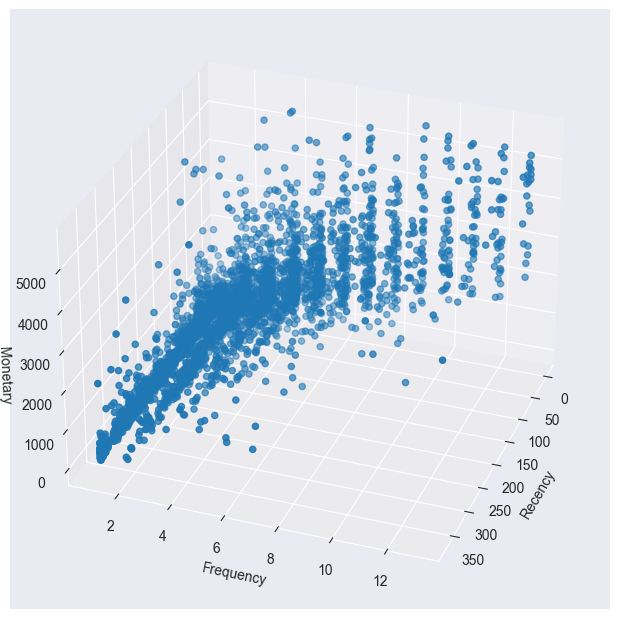

In [173]:
# создадим трёхмерный объект
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
# добавим дополнительную ось в объект картинки
fig.add_axes(ax)
ax.azim = 20
ax.elev = 30

# визуализируем данные, передав значения x, y, z, а также информацию о группировке данных по цветам
ax.scatter(
    rfm_table_cleaned['Recency'].to_list(), 
    rfm_table_cleaned['Frequency'].to_list(),
    rfm_table_cleaned['Monetary'].to_list()
)
# добавим оси
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary');


Видно, что есть клиенты с большими значениями параметров Monetary и Frequency — вероятно, это лучшие клиенты, которые покупают чаще всего и приносят больше всего денег.


### Задание 5.3
Для стабильной работы метода главных компонент (PCA) данные необходимо стандартизировать/нормализовать. 

In [215]:
pipeline = Pipeline([('scaler', StandardScaler()), 
                ('pca', PCA(n_components=2))])

rfm_table_processed = pipeline.fit_transform(rfm_table_cleaned)

pipeline['pca'].explained_variance_ratio_[0]

0.6773728319725008

Визуализировав пространство главных компонент после декомпозиции мы получим следующую картину:

,0,1
0,-2.135312,1.401346
1,3.447584,0.853780
2,0.629387,0.083455
3,0.153080,-0.720684
4,-1.888870,1.382468
...,...,...
4039,-0.873707,-0.729047
4040,-1.806045,1.051594
4041,-1.420996,0.168214
4042,-0.319068,-1.198275


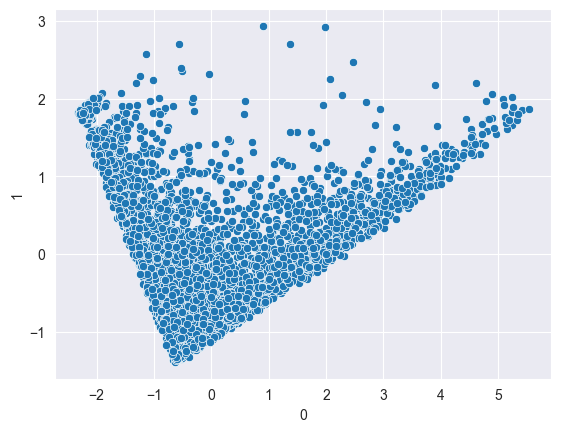

In [186]:
rfm_table_processed = pd.DataFrame(rfm_table_processed)
display(rfm_table_processed)
sns.scatterplot(data=rfm_table_processed, x=0, y=1);

Попробуем разделить это пространство главных компонент на сегменты. 

### Задание 5.4
Воспользуемся методом k-means. 

Переберём возможные значения кластеров от 2 до 10. 


'Максимальное значение коэффициента силуэта = 0.52'

<Axes: xlabel='cluster', ylabel='silhouette'>

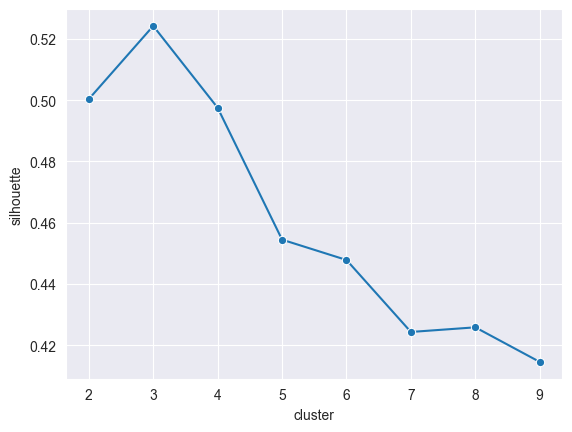

In [182]:
def get_silhouette_kmeans(cluster_num, X):
    k_means =  KMeans(n_clusters=cluster_num, init='k-means++', random_state=42)
    k_means.fit(X)
    silhouette = silhouette_score(X, k_means.predict(X))
    return silhouette

silhouette_res = {"silhouette": [], "cluster": []}

X = rfm_table_processed

for cluster_num in range(2, 10):
    silhouette_res["silhouette"].append(get_silhouette_kmeans(cluster_num, X))
    silhouette_res["cluster"].append(cluster_num)

silhouette_df_kmeans = pd.DataFrame(silhouette_res)
display(f'Максимальное значение коэффициента силуэта = {silhouette_df_kmeans['silhouette'].max():.2f}')

sns.set_style("darkgrid")
sns.lineplot(data=silhouette_df_kmeans, x="cluster", y="silhouette", marker= "o")

### Задание 5.5
Теперь возьмём EM-алгоритм.

Подберите оптимальное количество кластеров для EM-алгоритма (GaussianMixture) с помощью коэффициента силуэта, перебирая возможные значения от 2 до 10 включительно.
В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.


1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.


'Максимальное значение коэффициента силуэта = 0.44'

<Axes: xlabel='cluster', ylabel='silhouette'>

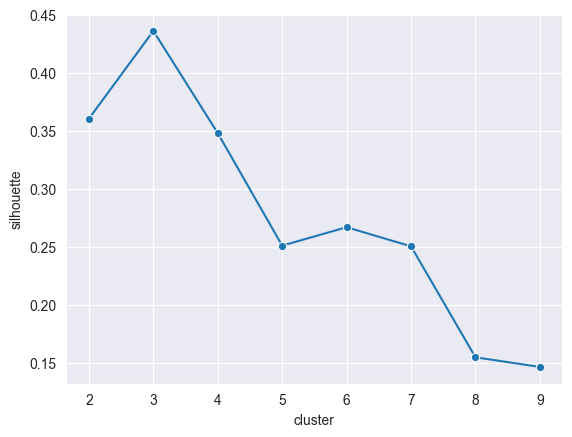

In [183]:
def get_silhouette_em(cluster_num, X):
    gm_clustering = GaussianMixture(n_components=cluster_num, random_state=42)
    gm_clustering.fit(X)
    silhouette = silhouette_score(X, gm_clustering.predict(X))
    return silhouette

silhouette_res_em = {"silhouette": [], "cluster": []}

X = rfm_table_processed

for cluster_num in range(2, 10):
    silhouette_res_em["silhouette"].append(get_silhouette_em(cluster_num, X))
    silhouette_res_em["cluster"].append(cluster_num)

silhouette_df_em = pd.DataFrame(silhouette_res_em)
display(f'Максимальное значение коэффициента силуэта = {max(silhouette_res_em['silhouette']):.2f}')

sns.set_style("darkgrid")
sns.lineplot(data=silhouette_res_em, x="cluster", y="silhouette", marker= "o")

### Задание 5.6
Посмотрим на распределение кластеров.

Обучим KMeans модель, так как коэффициент силуэта у неё выше.



In [197]:
k_means =  KMeans(n_clusters=3, random_state=42)
k_means.fit(rfm_table_processed)

prediction = k_means.predict(rfm_table_processed)
rfm_table_processed['Label'] = prediction

Label
1    2266
0    1001
2     777
Name: count, dtype: int64

,axis-1,axis-2,Label
0,-2.135312,1.401346,0
1,3.447584,0.853780,2
2,0.629387,0.083455,1
3,0.153080,-0.720684,1
4,-1.888870,1.382468,0
...,...,...,...
4039,-0.873707,-0.729047,1
4040,-1.806045,1.051594,0
4041,-1.420996,0.168214,0
4042,-0.319068,-1.198275,1


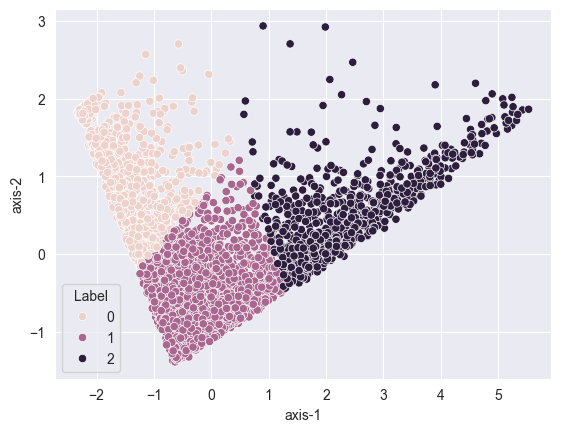

In [198]:
display(rfm_table_processed['Label'].value_counts())

sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2', hue='Label');
rfm_table_processed

### Задание 5.7

Вернёмся от декомпозированных данных к RFM-таблице

In [204]:
rfm_table_cleaned['Cluster'] = prediction
rfm_table_cleaned.groupby('Cluster').mean()

,Recency,Frequency,Monetary
Cluster,,,
0,253.283716,1.405594,386.491868
1,51.142542,2.327891,659.515384
2,31.924067,7.064350,2655.919846


### Полярная диаграмма
Используем Radar Chart для визуализации признаков.

Реализуем функцию plot_cluster_profile(), которая позволяет визуализировать профиль каждого из кластеров в виде полярной диаграммы.

Все признаки должны быть приведены к единому масштабу с помощью нормализации, где 1 будет означать максимум, а 0 — минимум.

In [205]:
def plot_cluster_profile(grouped_data, n_clusters):
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = preprocessing.MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    # список признаков
    features = grouped_data.columns
    
    fig = go.Figure()
    # визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # радиусы
            theta=features, # название засечек
            fill='toself', # заливка многоугольника цветом
            name=f'Cluster {i}', # название - номер кластера
        ))

    fig.update_layout(
        showlegend=True,
        autosize=False, 
        width=800, 
        height=800, 
    )
    
    fig.show()
    

### Задание 5.8

Визуализируем профили кластеров в виде полярной диаграммы на основе средних RFM-характеристик, вычисленных для каждого кластера. 


In [207]:
rfm_table_cleaned = rfm_table_cleaned[['Recency',	'Frequency',	'Monetary']]
plot_cluster_profile(rfm_table_cleaned, 3)

Описание кластеров:
* Кластер 1 - соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
* Кластер 2 - соответствует «промежуточным» клиентам, которые являются активными, но покупают не так часто и много, как лояльные клиенты.
* Кластер 3 - соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена очень давно.

### 6. RFM-сегментация клиентов: часть 2

Итак, с помощью RFM-анализа нам удалось выделить три сегмента клиентов. Однако в маркетинге принято оперировать большим их количеством: обычно маркетологи стараются создать стратегию хотя бы для пяти-семи клиентских сегментов в градации от «лояльных» до «потерянных» с промежуточными категориями.

Поэтому, получив обратную связь от маркетологов, мы вновь принимаемся за работу, пытаясь модифицировать полученное решение.

Ранее мы производили кластеризацию в пространстве главных компонент. Вспомним, что PCA является линейным методом отображения исходного пространства признаков в его сжатую версию.

А что если использовать нелинейную трансформацию? Например, алгоритм снижения размерности t-SNE. Давайте попробуем и посмотрим, что получится.

### Задание 6.1
Воспользуемся алгоритмом t-SNE и трансформируем RFM-таблицу, очищенную от выбросов, в двухмерное представление.



In [222]:
pipeline_tsne = Pipeline([('scaler', StandardScaler()), 
                ('tsne', TSNE(perplexity=50, random_state=100))])

rfm_table_tsne = pipeline_tsne.fit_transform(rfm_table_cleaned)

In [226]:
rfm_table_tsne = pd.DataFrame(rfm_table_tsne)
rfm_table_tsne

,0,1
0,-5.158021,32.686302
1,19.332361,29.282167
2,30.257988,-2.148945
3,8.825777,-19.503326
4,-8.607056,27.206860
...,...,...
4039,-48.572624,-9.775546
4040,-16.742250,29.532349
4041,-39.279633,14.765291
4042,-8.380754,-42.346241


Визуализировав пространство после декомпозиции с помощью t-SNE, мы получим следующую картину:


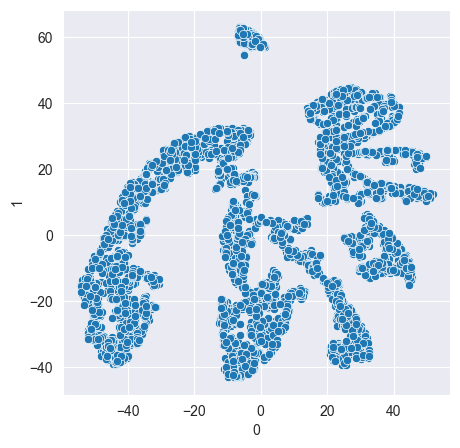

In [227]:
fig = plt.figure(figsize=(5, 5))
sns.scatterplot(data=rfm_table_tsne, x=0, y=1); 

t-SNE алгоритм сгруппировал наиболее похожие объекты в подобие кластеров.


### Задание 6.2
Снова воспользуемся методом k-means после преобразований t-SNE алгоритма. 



'Максимальное значение коэффициента силуэта = 0.50'

<Axes: xlabel='cluster', ylabel='silhouette'>

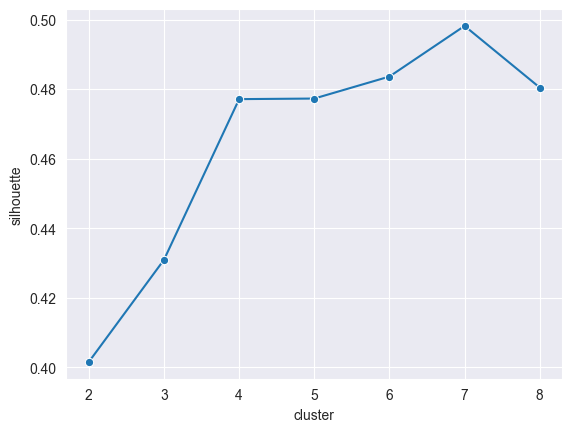

In [230]:
silhouette_res = {"silhouette": [], "cluster": []}

X = rfm_table_tsne

for cluster_num in range(2, 9):
    silhouette_res["silhouette"].append(get_silhouette_kmeans(cluster_num, X))
    silhouette_res["cluster"].append(cluster_num)

silhouette_df_kmeans = pd.DataFrame(silhouette_res)
display(f'Максимальное значение коэффициента силуэта = {silhouette_df_kmeans['silhouette'].max():.2f}')

sns.set_style("darkgrid")
sns.lineplot(data=silhouette_df_kmeans, x="cluster", y="silhouette", marker= "o")

### Задание 6.3
Попробуем воспользоваться EM-алгоритом. 

Подберите оптимальное количество кластеров для EM-алгоритма (GaussianMixture)  с помощью коэффициента силуэта, перебирая возможные значения от 3 до 8 включительно. 

В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.


1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.

### Задание 6.4
Наконец, попробуем воспользоваться алгоритмом алгомеративной кластеризации (AgglomerativeClustering).

Подберите оптимальное количество кластеров для алгоритма агломеративной кластеризации с помощью коэффициента силуэта, перебирая возможные значения от 2 до 8 включительно. 

Все параметры, за исключением числа кластеров, оставьте по умолчанию.


1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.



### Задание 6.5
Давайте посмотрим на распределение кластеров.

1) Сначала нужно определить лучшую модель. Для какой модели с оптимальным количеством кластеров коэффициент силуэта наибольший?
* K-Means
* GaussianMixture
* AgglomerativeClustering


2) Обучите лучшую модель с подобранным ранее количеством кластеров на декомпозированных данных. 
Сколько клиентов попало в самый большой кластер?



Визуализируем результаты кластеризации:

In [202]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2', hue=model.labels_.astype('str'));

NameError: name 'model' is not defined

<Figure size 1200x500 with 0 Axes>


Итак, у нас есть 7 сегментов клиентов. Давайте попробуем составить профиль для этих сегментов. 


### Задание 6.6

Для составления профиля кластеров нам необходимо вернуться от декомпозированных данных к RFM-таблице (очищенной от выбросов).

Сгруппируйте RFM-таблицу по полученным кластерам и рассчитайте среднее по каждому из признаков. Для наглядности округлите все значения в столбцах до целого числа.

Чему равно максимальное среднее значение признака Recency в полученной таблице? Ответ округлите до целого числа.

### Задание 6.7
Визуализируйте профили кластеров в виде полярной диаграммы на основе средних RFM-характеристик, вычисленных для каждого кластера.

Проанализируйте кластеры и на основе анализа сопоставьте номер кластера и его описание.

* Кластер соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
* Кластер соответствует «перспективным» клиентам, которые являются активными покупателями, но покупают не так часто и не так много, как лояльные клиенты.
* Кластер соответствует «подвисшим» клиентам, которые относительно недавно сделали несколько заказов на небольшие суммы. Потенциально эти клиенты могут быть переведены в кластер «перспективных».
* Кластер соответствует клиентам «в зоне риска», которые несколько раз покупали товары на небольшие суммы, однако их последняя покупка была совершена более пяти месяцев назад.
* Кластер соответствует клиентам-«новичкам», которые относительно недавно сделали один заказ на небольшую сумму. 
* Кластер соответствует «спящим» или «почти потерянным» клиентам, которые сделали один заказ на маленькую сумму более семи месяцев назад и больше не возвращались.
* Кластер соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена около года назад.



## 7. RFM-кластеризация клиентов: часть 3

Мы построили модель кластеризации для части клиентов.Но как сделать предсказание сегмента для клиентов, которые не попали в обучающую выборку?

Вы, вероятно, скажете: «Воспользоваться методом predict()!»

Верно, однако всё не так просто.

Вспомним, что мы обучали наши алгоритмы кластеризации на сжатом с помощью t-SNE пространстве признаков. То есть, чтобы сделать предсказание для новых объектов, не попавших в выборку, нам необходимо будет совершить трансформацию признаков этих объектов в новое сжатое пространство. 

Однако проблема t-SNE заключается в том, что алгоритм непараметрический. Это значит, что он, в отличие от таких алгоритмов, как PCA и SVD, не создаёт явной функции отображения. Проще говоря, алгоритм трансформирует пространство признаков для обучающей выборки, но не запоминает, каким образом это делает. Это значит, что, передав в алгоритм новые объекты для сжатия пространства, мы получим абсолютно новое представление пространства, не имеющее отношения к тому, что мы построили для обучающей выборки. То есть произойдёт искажение, что может привести к неверным результатам кластеризации.

Именно поэтому у класса TSNE из библиотеки sklearn нет такого метода, как transform(), у него есть только метод fit_transform() — заново обучить алгоритм t-SNE и произвести трансформацию.

Как же тогда производить кластеризацию для новых объектов, если мы не можем сжимать размерность для новых данных?

Давайте сведём задачу кластеризации к задаче классификации. Действительно, у нас теперь есть истинные метки кластеров, а есть клиенты, которые описываются RFM-характеристиками. Давайте обучим модель, которая на основе RFM-характеристик будет предсказывать клиентский сегмент. 

### Задание 7.1

Разделите исходные данные на тренировочную и тестовую выборки в соотношении 80/20. В качестве параметра random_state возьмите число 42.

Сколько клиентов попали в тестовую выборку?

Дальше нам осталось только построить несколько моделей и выбрать из них лучшую. 
Мы знаем, что алгоритм t-SNE является нелинейным методом понижения размерности. Можно смело предположить, что линейные модели, такие как логистическая регрессия, в данной задаче нам мало чем помогут (можете убедиться в этом самостоятельно, обучив модель логистической регрессии на тренировочной выборке и оценив качество на тестовой).

Поэтому давайте сразу возьмём тяжелую артиллерию — ансамблевые алгоритмы. 


### Задание 7.2
Начнём со случайного леса. С помощью GridSearchCV организуйте перебор параметров случайного леса (RandomForestClassifier) на следующей сетке параметров:

```
param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}
```
В качестве параметра random_state для модели случайного леса используйте число 42.
В качестве метрики используйте accuracy. Количество фолдов для кросс-валидации — 5.

1) Обучите GridSearchCV на тренировочной выборке. Чему равна оптимальная максимальная глубина деревьев в случайном лесу?

2) С помощью лучшей модели сделайте предсказание для тестовой выборки и рассчитайте метрику accuracy. Ответ округлите до трёх знаков после точки-разделителя.



Итак, значение метрики accuracy очень высокое, но не идеальное. Давайте попробуем его улучшить, воспользовавшись бустингом.

### Задание 7.3
С помощью GridSearchCV организуйте перебор параметров градиентного бустинга (GradientBoostingClassifier) на следующей сетке параметров:
```
param_grid = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}
```

В качестве параметра random_state для модели градиентного бустинга используйте число 42.
В качестве метрики используйте accuracy. Количество фолдов для кросс-валидации — 5. 

1) Обучите GridSearchCV на тренировочной выборке. Чему равна оптимальная максимальная глубина деревьев в градиентном бустинге?
Ответ: 6
2) С помощью лучшей модели сделайте предсказание для тестовой выборки и рассчитайте метрику accuracy. Ответ округлите до трёх знаков после точки-разделителя.



Отлично, мы справились с проблемой непараметричности t-SNE и смогли перейти от решения задачи кластеризации к задаче классификации. Теперь у нас есть модель, которая на основе RFM-характерик клиента автоматически определяет его сегмент.